Let's consider different models describing relative motion between satellites in LEO orbits in the notebook.

We will have a look at three different ones:

- $\textbf{Nonlinear relative motion model}$ suitable for arbitratry intersatellite distances and keplerian motion
- $\textbf{Classical linearized Hill-Clohessy-Wiltshire (HCW) model}$ assuming leader satellite motion along a circular orbit
- $\textbf{Linearized HCW model written in curvilinear cylindrical frame}$

The following reference frames are to be used throughout the notebook.

<!-- ![reference_frames.jpg](attachment:reference_frames.jpg) -->
<img src="reference_frames.jpg" width="500" height="340"> 
Nevertheless, at first glance the one could explore the relative motion between satellites by the basic numerical integration of the following equations describing orbital motion dynamics of each individual satellite.

$ \begin{cases} 
\ddot{\mathbf{R}}_l = - \frac{\mu \mathbf{R}_l}{{R}_l^3}, \\
\ddot{\mathbf{R}}_f = - \frac{\mu \mathbf{R}_f}{{R}_f^3}.
\end{cases} $

Solving the equations numerically a one can obtain position and velocity for certain period of time for both satellites - $\mathbf{R}_l(t), \mathbf{V}_l(t)$ and $\mathbf{R}_f(t), \mathbf{V}_f(t)$.

The relative motion of follower satellite with respect to the leader is can be expressed then as follows

$\mathbf{r} = \mathbf{R}_f - \mathbf{R}_l $

Nevertheless, the relative position will be given with respect to the inertial frame. 
Therefore, to get a clearer insight into the relative motion an orbital frame might be used.

Let's us consider the orbital reference frame $\mathbf{e}_{\theta}, \mathbf{e}_{h}, \mathbf{e}_{r}$ with a transformation matrix $\mathbf{A}^{IO}$

$ \mathbf{r}(t) = \mathbf{A}^{IO}(t) \cdot \boldsymbol{\rho}(t) $, 

where $\boldsymbol{\rho}$ is follower satellite relative position vector given in the orbital frame, A is calculated as follows

$\mathbf{A}^{IO} = [\mathbf{e}_{\theta}, \mathbf{e}_{h}, \mathbf{e}_{r}]$,

$ \mathbf{e}_{r} = \frac{\mathbf{R}_l}{R_l}, \mathbf{e}_{h} = \frac{\mathbf{R}_l \times \mathbf{V}_l}{|\mathbf{R}_l \times \mathbf{V}_l|}, \mathbf{e}_{\theta} = \mathbf{e}_{h} \times \mathbf{e}_{r}$.

Evertually, the relative position vector given in the orbital frame can be found as follows

$ \boldsymbol{\rho} = \mathbf{A}^{OI}(t) \cdot (\mathbf{R}_f - \mathbf{R}_l) $

where $\mathbf{A}^{OI} =  \left(\mathbf{A}^{IO}\right)^{\top}$



In [1]:
import numpy as np
import math
import scipy as sci
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

from scipy.integrate import solve_ivp

In [2]:
class Parameters():
    pass

cnst = Parameters()   # global parametres
cnst.mu = 3.986e14    # m^3 /s^2
cnst.re = 6371e3      # m

In [3]:
# rhs functions for point mass problem

def rhs_central_gravity(t, x):    
    # Rhs for orbital motion equations for single satellite

    gravity_acc = np.zeros(3)
    norm_r = np.linalg.norm(x[0:3])

    gravity_acc[0] = - cnst.mu * x[0] / (norm_r**3)
    gravity_acc[1] = - cnst.mu * x[1] / (norm_r**3)
    gravity_acc[2] = - cnst.mu * x[2] / (norm_r**3)

    dxdt = np.zeros(6)
    dxdt[0:3] = x[3:6]
    dxdt[3:6] = gravity_acc

    return dxdt

def rhs_central_gravity_2sats(t, x):    
    # Rhs for orbital motion equations for two satellites
    
    # state, x = [r1, v1, r2, v2]

    dxdt = np.zeros(12)

    # satellite 1
    gravity_acc1 = np.zeros(3)
    norm_r1 = np.linalg.norm(x[0:3])

    gravity_acc1[0] = - cnst.mu * x[0] / (norm_r1**3)
    gravity_acc1[1] = - cnst.mu * x[1] / (norm_r1**3)
    gravity_acc1[2] = - cnst.mu * x[2] / (norm_r1**3)

    dxdt[0:3] = x[3:6]
    dxdt[3:6] = gravity_acc1
    
    # satellite 2
    gravity_acc2 = np.zeros(3)
    norm_r2 = np.linalg.norm(x[6:9])

    gravity_acc2[0] = - cnst.mu * x[6] / (norm_r2**3)
    gravity_acc2[1] = - cnst.mu * x[7] / (norm_r2**3)
    gravity_acc2[2] = - cnst.mu * x[8] / (norm_r2**3)

    dxdt[6:9] = x[9:12]
    dxdt[9:] = gravity_acc2

    return dxdt

In [4]:
# functions, state transformation mainly     

def normalize(x):        # calculates a unit direction vector

    return x / np.linalg.norm(x)


def calc_A_IO(rv_ECI):         # calculates transformation matrix x_eci = A_IO * x_orb

    r = rv_ECI[0:3, 0]
    v = rv_ECI[3:, 0]

    A_IO = np.zeros((3, 3))
    
    A_IO[:, 2] = normalize(r)
    A_IO[:, 1] = normalize(np.cross(r, v))
    A_IO[:, 0] = normalize(np.cross(A_IO[:, 1], A_IO[:, 2]))
    
    energy_sp = np.linalg.norm(v)**2 / 2 - cnst.mu / np.linalg.norm(r)
    sma = -cnst.mu / 2 / energy_sp
    
    n = np.sqrt(cnst.mu / sma**3)
    
    return A_IO, n


def calc_A_OI(rv_ECI):         # calculates transformation matrix x_orb = A_OI * x_eci

    A_IO, n = calc_A_IO(rv_ECI)
    A_OI = A_IO.transpose()
    
    return A_OI, n


def hcw_geometric2cart(e, n, t):           # calculates cartesian relative state using a set of HCW constants

    # e = [c1, rho1, rho2, c4, alpa1, alpha2]
    c1 = e[0]
    rho1 = e[1]
    rho2 = e[2]
    c4 = e[3]
    alpha1 = e[4]
    alpha2 = e[5]
    
    rv_rel = np.zeros([6, 1])
    
    rv_rel[0] = 3 * c1 * n * t + rho1 * np.cos(n * t + alpha1) + c4
    rv_rel[1] = rho2 * np.sin(n * t + alpha2)
    rv_rel[2] = -2 * c1 + rho1 / 2 * np.sin(n * t + alpha1)
    
    rv_rel[3] = 3 * c1 * n - n * rho1 * np.sin(n * t + alpha1)
    rv_rel[4] = n * rho2 * np.cos(n * t + alpha2)
    rv_rel[5] = rho1 / 2 * n * np.cos(n * t + alpha1)
    
    return rv_rel


def state_orb2eci(rv_leader_eci, rv_orb):    # transforms relative state given in orb rf to inertial state

    A_IO, n = calc_A_IO(rv_leader_eci)
    
    r_orb = np.array(rv_orb[0:3, 0])
    v_orb = np.array(rv_orb[3:, 0])
        
    r_I = np.dot(A_IO, r_orb) + np.array(rv_leader_eci[0:3, 0])
    
    ang_vel = np.array([0, n, 0])
                        
    v_I = np.dot(A_IO, v_orb + np.cross(ang_vel, r_orb)) + np.array(rv_leader_eci[3:, 0])
    rv_I = np.zeros(6)
    rv_I[0:3] = r_I
    rv_I[3:] = v_I

    return rv_I


def state_eci2orb(rv_leader, rv_follower):    # transforms inertial state to relative state given in orb rf
    
    A_OI, n = calc_A_OI(rv_leader)
    
    r_O = np.array(np.dot(A_OI, rv_follower[0:3, 0] - rv_leader[0:3, 0]))
    
    v_rel =  np.array(rv_follower[3:, 0] - rv_leader[3:, 0])
    
    ang_vel = np.array([0, n, 0]) 
    v_rel_O = np.dot(A_OI, v_rel) - np.cross(ang_vel, r_O)
    
    rv_rel_orb = np.zeros(6)
    rv_rel_orb[0:3] = r_O
    rv_rel_orb[3:] = v_rel_O
    
    return rv_rel_orb

For simplicity and without los of generality let's consider leader satellite in circular equatorial LEO orbit with the altitude of 400 km

In [5]:
# Define leader satellite orbit
# circular equatorial orbit, 400 km altitude

alt_leader = 400e3
rv0_leader = np.array([[cnst.re + alt_leader], [0], [0], [0], [np.sqrt(cnst.mu / (cnst.re + alt_leader))], [0]])

orbit_period = 2 * np.pi * np.sqrt((rv0_leader[0]**3 / cnst.mu))

In [6]:
# Defining follower satellite orbit yeilding certain periodic relative trajectory

n = calc_A_IO(rv0_leader)[1] # leader satellite's mean motion

# e = [c1, rho1, rho2, c4, alpha1, alpha2]
e = np.array([0, 1000, 500, 1000, 0, 0])    # relative orbital elements or HCW constants

rv0_follower_rel_orb = hcw_geometric2cart(e, n, 0)    # finds cartesion relative state of the follower satellite given in orb rf 

rv0_follower = state_orb2eci(rv0_leader, rv0_follower_rel_orb) # eci state of the follower

In [7]:
# Numerical simulation of two satellites motion around spherical Earth

t_step = 10 # seconds
t_simulation = orbit_period * 10
t_array = np.arange(1, t_simulation, t_step)

sol_two_sats_point_mass = solve_ivp(rhs_central_gravity_2sats, (0, t_simulation), \
                                    np.concatenate((rv0_leader.flatten(), rv0_follower.flatten())), t_eval = t_array, \
                                    rtol=1e-10, atol=1e-10)

rv_two_sats_point_mass = sol_two_sats_point_mass.y[0:12, :]
rv_leader_point_mass = rv_two_sats_point_mass[0:6, :]
rv_follower_point_mass = rv_two_sats_point_mass[6:, :]

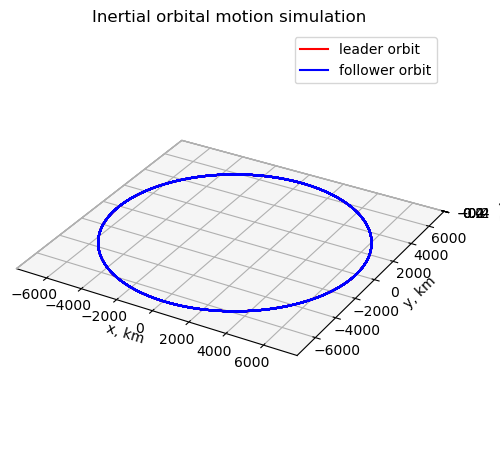

In [8]:
# Plotting numerical simulation results for two satellites

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(rv_leader_point_mass[0, :] / 1e3, rv_leader_point_mass[1, :] / 1e3, rv_leader_point_mass[2, :] / 1e3, 'r', \
        label='leader orbit')
ax.plot(rv_follower_point_mass[0, :] / 1e3, rv_follower_point_mass[1, :] / 1e3, rv_follower_point_mass[2, :] / 1e3, 'b', \
        label='follower orbit')

ax.legend()

ax.set_title('Inertial orbital motion simulation')
ax.set_xlabel(r'x, km')
ax.set_ylabel(r'y, km')
ax.set_zlabel(r'z, km')

plt.gca().set_aspect('equal')

plt.tight_layout()

In [9]:
# let's find relative motion of the follower spacecraft wrt to the orb frame

r_rel_O = np.zeros((3, rv_leader_point_mass.shape[1]))

for timeIdx in range(t_array.shape[0]):
        
    rv_leader_local = rv_leader_point_mass[:, timeIdx]
    rv_follower_local = rv_follower_point_mass[:, timeIdx]
    
    r_rel_O_local = state_eci2orb(rv_leader_local[:, np.newaxis], rv_follower_local[:, np.newaxis])
    r_rel_O[:, timeIdx] = r_rel_O_local[0:3]

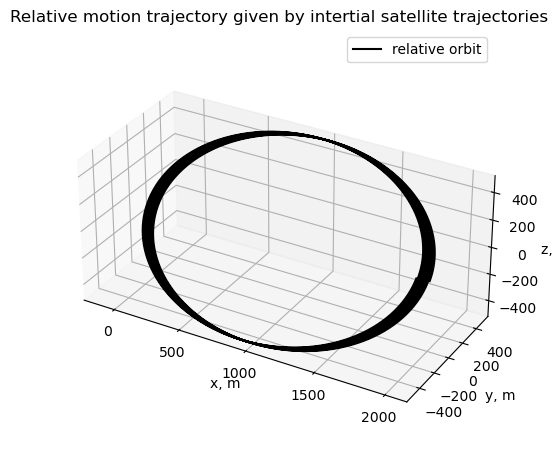

In [10]:
# Plotting follower relative orbit wrt to the orb frame

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(r_rel_O[0, :], r_rel_O[1, :], r_rel_O[2, :], 'k', label='relative orbit')

ax.legend()

ax.set_title('Relative motion trajectory given by intertial satellite trajectories')
ax.set_xlabel(r'x, m')
ax.set_ylabel(r'y, m')
ax.set_zlabel(r'z, m')

plt.gca().set_aspect('equal')

plt.tight_layout()

Let's now consider nonlinear relative motion model for general case meaning any kind of relative distances. The only assumption is unperturbed or keplerian motion of both leader and follower satellites


$ \begin{cases} 
\ddot{x} = - \frac{\mu x}{(x^2 + y^2 + (r + z)^2)^{3/2}} + \frac{h^2}{r^4}x + 2\frac{h}{r^2}(\frac{\dot{r}}{r}z - \dot{z}) \\
\ddot{y} = - \frac{\mu y}{(x^2 + y^2 + (r + z)^2)^{3/2}} \\
\ddot{z} = - \frac{\mu (r + z)}{(x^2 + y^2 + (r + z)^2)^{3/2}} + \frac{\mu}{r^2} + \frac{h^2}{r^4}z + 2\frac{h}{r^2}(\dot{x} - \frac{\dot{r}}{r}x)
\end{cases} $

where $h = |\mathbf{r} \times \mathbf{v}|$ - leader's specific angular momentum, $\dot{r} = \mathbf{v} \cdot \mathbf{e}_r$ - leader's position vector length change rate

In [11]:
# Nonlinear differential equations of satellite relative motion dynamics

def rhs_nonlinear_relative(t, x):    
    # Rhs for nonlinear relative motion
    # Requires to know leader's state as well
    # Therefore leader's motion equations are in the loop

    # x = [r_leader, v_leader, r_relative, v_relative]
    
    dxdt = np.zeros(12)
    
    # leader's motion equations - point mass model
    dxdt[0:3] = x[3:6]

    gravity_acc = np.zeros(3)
    norm_r_leader = np.linalg.norm(x[0:3])
    gravity_acc[0] = - cnst.mu * x[0] / (norm_r_leader**3)
    gravity_acc[1] = - cnst.mu * x[1] / (norm_r_leader**3)
    gravity_acc[2] = - cnst.mu * x[2] / (norm_r_leader**3)
    
    dxdt[3:6] = gravity_acc
    
    
    # follower's nonlinear relative motion equations wrt to orb frame
    dxdt[6:9] = x[9:12]
    
    norm_r_follower = ((norm_r_leader + x[8])**2 + x[6]**2 + x[7]**2)**(1/2)
    
    h_leader = np.linalg.norm(np.cross(x[0:3], x[3:6]))
    
    r_leader_dot = np.dot(normalize(x[0:3]), x[3:6]) # leader position vector magnitude change rate

    dxdt[9] = -cnst.mu * x[6] / norm_r_follower**3 + \
                h_leader**2 / norm_r_leader**4 * x[6] + \
                2 * h_leader / norm_r_leader**2 * (r_leader_dot / norm_r_leader * x[8] - x[11])

    dxdt[10] = -cnst.mu * x[7] / norm_r_follower**3
    
    dxdt[11] = -cnst.mu * (norm_r_leader + x[8]) / norm_r_follower**3 \
                +cnst.mu / norm_r_leader**2 \
                + h_leader**2 / norm_r_leader**4 * x[8] + \
                2 * h_leader / norm_r_leader**2 * (x[9] - r_leader_dot / norm_r_leader * x[6])
    
    
    return dxdt

In [12]:
# Let's solve the nonlinear equations of motion numerically

# applying the same initial conditions as previously

sol_two_sats_nonlinear = solve_ivp(rhs_nonlinear_relative, (0, t_simulation), np.concatenate((rv0_leader.flatten(), rv0_follower_rel_orb.flatten())), t_eval = t_array, rtol=1e-10, atol=1e-10)

rv_two_sats_nonlinear = sol_two_sats_nonlinear.y[0:12, :]
rv_leader_nonlinear = rv_two_sats_nonlinear[0:6, :]
rv_follower_relative_nonlinear = rv_two_sats_nonlinear[6:, :]

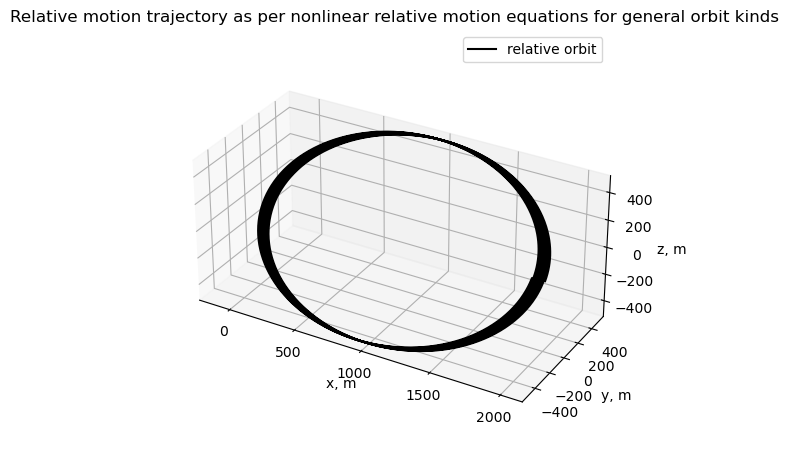

In [13]:
# Let's visualize relative motion trajectory obtained with nonlinear relative motion equations

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(rv_follower_relative_nonlinear[0, :], \
        rv_follower_relative_nonlinear[1, :], \
        rv_follower_relative_nonlinear[2, :], \
        'k', label='relative orbit')

ax.legend()

ax.set_title('Relative motion trajectory as per nonlinear relative motion equations for general orbit kinds')
ax.set_xlabel(r'x, m')
ax.set_ylabel(r'y, m')
ax.set_zlabel(r'z, m')

plt.gca().set_aspect('equal')

plt.tight_layout()

Let's now consider linearized relative motion HCW model (Hill-Clohessy-Wiltshire equations) for circular leader orbit suitable for short relatively relative distances.


$ \begin{cases} 
\ddot{x} = - 2n\dot{z} \\
\ddot{y} = - n^2y \\
\ddot{z} = 2n\dot{x} + 3n^2z
\end{cases} $

where $n = \sqrt{\frac{\mu}{r^3}}$ is the leader's orbit mean motion

In [14]:
# Linearized HCW differential equations of satellite relative motion

def rhs_HCW(t, x, n):    
    # Rhs for HCW equations for single satellite
    
    dxdt = np.zeros(6)
    
    dxdt[0:3] = x[3:6]

    dxdt[3] = - 2 * n * x[-1]
    dxdt[4] = -n**2 * x[1]
    dxdt[5] = 2 * n * x[3] + 3 * n**2 * x[2]
    
    return dxdt


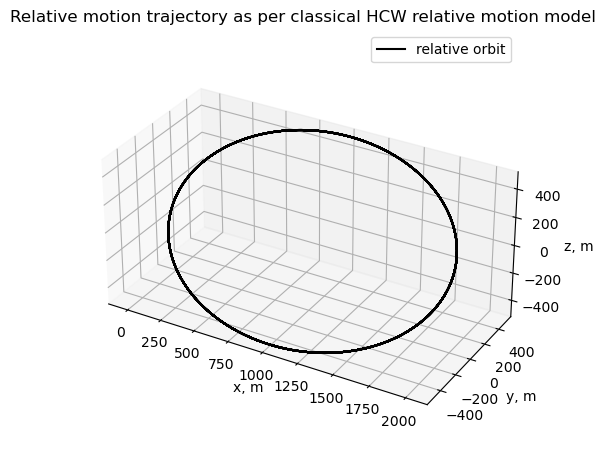

In [15]:
# Let's solve the linearized HCW equations of motion numerically

# applying the same initial conditions as previously

sol_HCW_cart = solve_ivp(lambda t,x: rhs_HCW(t, x, n), (0, t_simulation), rv0_follower_rel_orb.flatten(), t_eval = t_array, rtol=1e-10, atol=1e-10)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol_HCW_cart.y[0, :], \
        sol_HCW_cart.y[1, :], \
        sol_HCW_cart.y[2, :], \
        'k', label='relative orbit')

ax.legend()

ax.set_title('Relative motion trajectory as per classical HCW relative motion model')
ax.set_xlabel(r'x, m')
ax.set_ylabel(r'y, m')
ax.set_zlabel(r'z, m')

plt.gca().set_aspect('equal')

plt.tight_layout()

Finally, we consider linearized HCW model written in curvilinear coordinates. 
Let's consider cylindrical coordniates $\delta s, y, \delta r$, where $\delta s = r \delta \theta$ such that 


$ \begin{cases} 
x = r \delta \theta = \delta s \\
y = y \\
z = \delta r
\end{cases} $

Let's denote cartesian state given in orbital rf as $\boldsymbol{\rho} = [x, y, z]^{\top}$ and cylindrical as $\boldsymbol{\xi} = [\delta s, y, \delta r]^{\top}$

The following nonlinear mapping procedure is applied 
- $\textbf{Cartesian to Cylindrical}$

$ \begin{cases}
\delta s = r \cdot acos\left(\frac{r + z}{\sqrt{(r + z)^2 + x^2}}\right) \cdot sng(x) \\
y = y \\
\delta r = \sqrt{x^2 + (r + z)^2} - r\\
[\dot{\delta s}, \dot{y}, \dot{\delta r}]^{T} = A^{\xi \rho} \cdot [\dot{x}, \dot{y}, \dot{z}]^{T},
\end{cases} $


where $A^{\xi \rho} = \begin{bmatrix}  
cos(\delta \theta) & 0 & -sin(\delta \theta)  \\
0 & 1 & 0 \\
sin(\delta \theta) & 0 & cos(\delta \theta)
\end{bmatrix} $


- $\textbf{Cylindrical to Cartisian}$

$\begin{cases}
\boldsymbol{\rho} = A^{\rho \xi} \cdot \begin{bmatrix} 0 \\ y \\ r + \delta r \end{bmatrix} - \
\begin{bmatrix} 0 \\ 0 \\ r \end{bmatrix} \\
\mathbf{v}_{\rho} = A^{\rho \xi} \cdot \mathbf{v}_{\xi}
\end{cases}$

where $ A^{\rho \xi} = (A^{\xi \rho})^{\top}$


Finally, the linearized equations of relative motion written in cylindrical coordinates are as follows

$ \begin{cases} 
\ddot{\delta s} = - 2n\dot{ \delta r} \\
\ddot{y} = - n^2y \\
\ddot{\delta r} = 2n\dot{\delta s} + 3n^2 \delta r
\end{cases} $

In [16]:
def rhs_HCW_curvilinear(t, x, n):    
    # Rhs for HCW equations given in cylindrical coordinates
    # [delta_s, y, delta_r, delta_s_dot, y_dot, delta_r_dot]
    # delta_s = r * delta_theta
    
    dxdt = np.zeros(6)
    
    dxdt[0:3] = x[3:6]
    
    dxdt[3] = - 2 * n * x[-1]
    dxdt[4] = -n**2 * x[1]
    dxdt[5] = 2 * n * x[3] + 3 * n**2 * x[2]
    
    return dxdt

def map_cart2cyl(x_cart, r):

    delta_r = np.sqrt(x_cart[0]**2 +  (r + x_cart[2])**2) - r
    delta_theta = math.acos((r + x_cart[2]) / (np.sqrt((r + x_cart[2])**2 + x_cart[0]**2))) * np.sign(x_cart[0])
    delta_s = delta_theta * r
    
    A_xi_rho = np.array([[math.cos(delta_theta), 0,  -math.sin(delta_theta)], \
                        [0, 1, 0], \
                        [math.sin(delta_theta), 0,  math.cos(delta_theta)]])
    
    v_xi = np.dot(A_xi_rho, x_cart[3:])

    x_cyl = np.zeros(6)
                           
    x_cyl[0] = delta_s
    x_cyl[1] = x_cart[1]
    x_cyl[2] = delta_r
    x_cyl[3:] = v_xi.flatten()
    
    return x_cyl

def map_cyl2cart(x_cyl, r):

    x_cart = np.zeros(6)
    
    delta_theta = x_cyl[0] / r
    
    A_rho_xi = np.array([[math.cos(delta_theta), 0,  math.sin(delta_theta)], \
                        [0, 1, 0], \
                        [-math.sin(delta_theta), 0,  math.cos(delta_theta)]])
    
    r_f0 = np.array([0,  x_cyl[1], x_cyl[2]])
    r_f0[2] += r

    r_l = np.zeros(3)
    r_l[2] += r
    
    rho = np.dot(A_rho_xi, r_f0) - r_l
    rho[1] = x_cyl[1]
    
    v_rho = np.dot(A_rho_xi, x_cyl[3:])    
    
    x_cart[0:3] = rho
    x_cart[3:] = v_rho
    
    return x_cart

Let's study the relative motion dynamics following the beforementioned initial conditions giving in orb frame,
$ \rho_1 = 1000 m, \rho_2 = 500 m, c_4 = 1000 m $.

The model should be more precise comparing to the classical HCW.

In [17]:
# Let's do nonlinear mapping between cartesian and cylindrical coordinates

rv0_orb_curv = map_cart2cyl(rv0_follower_rel_orb, rv0_leader[0])
print(rv0_orb_curv)

# numerical solve diff equations
rv_array_HCW_curv = solve_ivp(lambda t,x: rhs_HCW_curvilinear(t, x, n), (0, t_simulation), rv0_orb_curv.flatten(), t_eval = t_array, rtol=1e-10, atol=1e-10)


[ 1.99999994e+03  0.00000000e+00  2.95377338e-01 -1.67354192e-04
  5.66577640e-01  5.66577615e-01]


Let's see what happens to the coordinates

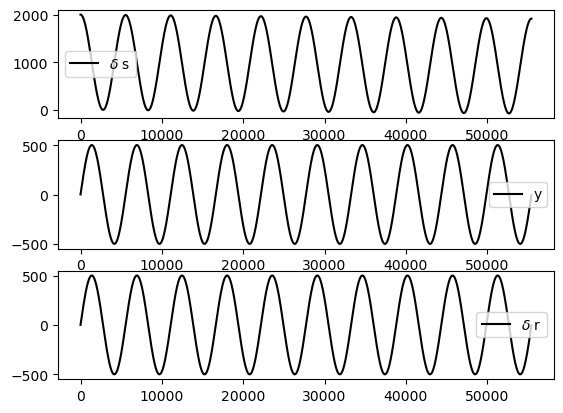

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(rv_array_HCW_curv.t, rv_array_HCW_curv.y[0], 'k', label='$\delta$ s')

ax2 = fig.add_subplot(312)
ax2.plot(rv_array_HCW_curv.t, rv_array_HCW_curv.y[2], 'k', label='y')


ax3 = fig.add_subplot(313)
ax3.plot(rv_array_HCW_curv.t, rv_array_HCW_curv.y[1], 'k', label='$\delta$ r')


ax1.legend()
ax2.legend()
ax3.legend()

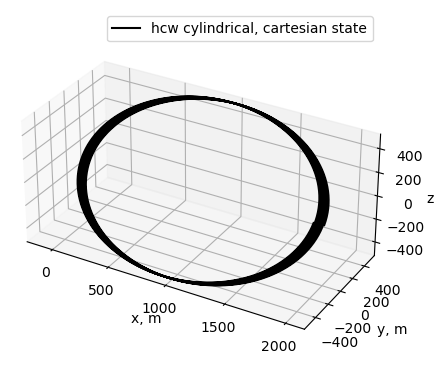

In [19]:
# converting satellite relative state from cylindrical to cartesian state

r_rel_cart = np.zeros((6, rv_array_HCW_curv.t.shape[0]))


for timeIdx in range(rv_array_HCW_curv.t.shape[0]):

    r_rel_сart_local = map_cyl2cart(rv_array_HCW_curv.y[:, timeIdx], rv0_leader[0])
    r_rel_cart[:, timeIdx] = r_rel_сart_local


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(r_rel_cart[0, :], r_rel_cart[1, :], r_rel_cart[2, :], 'k', label='hcw cylindrical, cartesian state')

ax.legend()

ax.set_xlabel(r'x, m')
ax.set_ylabel(r'y, m')
ax.set_zlabel(r'z, m')

plt.gca().set_aspect('equal')


Let's now see the precision of the relative motion models by comparison with nonlinear equations of relative motion

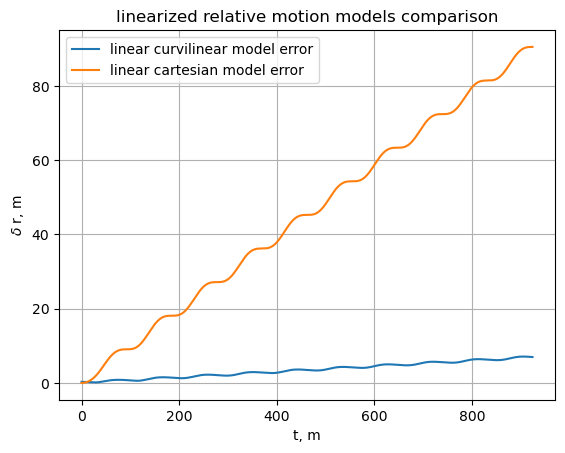

In [20]:
r_HCW_curv = rv_array_HCW_curv.y[0:3, :]
r_HCW_cart = sol_HCW_cart.y[0:3, :]
r_nonlinear = sol_two_sats_nonlinear.y[6:9, :]

erro_HCW_curv = np.linalg.norm(r_HCW_curv - r_nonlinear, axis=0)
erro_HCW_cart = np.linalg.norm(r_HCW_cart - r_nonlinear, axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol_two_sats_nonlinear.t / 60, erro_HCW_curv, label='linear curvilinear model error')
ax.plot(sol_two_sats_nonlinear.t / 60, erro_HCW_cart, label='linear cartesian model error')

ax.legend()

ax.set_title('linearized relative motion models comparison')
ax.set_xlabel(r't, m')
ax.set_ylabel(r'$\delta$ r, m')

plt.grid()